<a href="https://colab.research.google.com/github/harald-gen01/My_AI_learning_path/blob/main/Modular_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TLDR

This Colab demonstrates the full Modular RAG mental model:
**Retrieval (recall) → Judgment (answerability) → Generation (response)**
with **self-correction** as the reliability layer.

# Business View

This Colab demonstrates how to build a **production-ready AI assistant** that behaves safely and predictably.

Most AI assistants fail in enterprise settings because they:

* answer confidently even when evidence is weak
* rely on a single source of truth
* cannot handle fresh or changing information
* escalate costs through long prompts and retries

This Modular RAG workflow fixes that by introducing **control layers**:

### 1) Routing (Strategy)

The system decides where to look for evidence:

* **Internal knowledge** for policies, runbooks, and company truth
* **Web search** for time-sensitive or external information
* **Hybrid** when both could matter

This improves accuracy and prevents the most damaging failure mode:
answering internal questions using external sources, or answering current-event questions using stale internal docs.

### 2) Judgment (Quality Control)

Instead of “whatever retrieval returns,” the assistant **scores and selects** the best evidence and estimates confidence.

This reduces hallucinations and improves customer experience.

### 3) Self-correction (One Retry)

If evidence is weak, the system retries once:

* rewrites the query
* retrieves again
* re-evaluates the evidence

This adds reliability without uncontrolled cost.

### 4) Safe Refusal (Risk Reduction)

If confidence is below a threshold or the critic rejects the answer, the assistant responds:
**“I don’t know based on the provided evidence.”**

This is a feature: it protects customer trust, reduces escalations, and lowers compliance risk.

### Why this matters

This approach drives measurable outcomes:

* fewer wrong answers reaching customers
* fewer escalations to support teams
* faster resolution times
* predictable compute cost (limited retry)
* higher trust in AI-supported operations


# Explanation - Implementation View

This Colab implements a **LangGraph-based Modular RAG** system with:

* Router
* Internal retriever (Chroma Vector DB)
* Web retriever (Tavily Search)
* Evidence merge
* LLM re-ranker (judge)
* Grounded generator
* Critic gate
* Single retry loop
* Threshold-based refusal

It uses LangGraph because the workflow is **not linear**. It has:

* conditional routing
* merging of candidate sets
* a validation stage
* a bounded loop (retry once)



## 1) The graph state (single source of truth)

All nodes write into a shared `GraphState`, including:

* `query`
* `route`
* `internal_docs`, `web_docs`, `evidence_pool`
* `top_evidence`, `confidence`
* `draft_answer`, `critic_verdict`
* `retry_count`, `final_answer`

This makes the workflow debuggable and observable.



## 2) Node responsibilities (clear separation of concerns)

### `route_query`

Uses a small/cheap model to classify the query into:

* `internal`
* `web`
* `hybrid`

Outputs structured JSON:
`{route, reason}`



### `retrieve_internal`

Retrieves Top-K documents from Chroma.
Modern LangChain calls use:

```python
docs = internal_retriever.invoke(query)
```

Then we store:
`internal_docs = [doc.page_content ...]`



### `retrieve_web`

Uses Tavily to fetch fresh snippets.
Stores the result as short “documents” to control token cost.



### `merge_evidence`

Creates the evidence pool:

* union internal + web
* dedupe
* cap to max N chunks

This is the “shortlist” stage.



### `judge_rerank`

LLM-as-judge selects:

* best evidence index
* confidence score from 0.0–1.0

Important: this judges **answerability**, not similarity.

Outputs structured JSON like:

```json
{
  "best_index": 1,
  "confidence": 0.82,
  "rationale": "..."
}
```



### `generate_answer`

Main model generates the response grounded in one selected passage.

Rules enforced in prompt:

* only use the provided evidence
* if unsupported, respond with refusal



### `critic_check`

Small model validates grounding:

* PASS if evidence supports the answer
* FAIL if answer is generic or unsupported

Outputs structured JSON including suggested query rewrite.



### `rewrite_query` (self-correction)

Runs only when:

* critic FAIL
* retry_count < 1

This ensures bounded cost/latency.



### `finalize`

Implements the safety policy:

Return the answer only if:

* confidence >= threshold
* critic PASS

Otherwise refuse:
**“I don’t know based on the provided evidence.”**



## 3) Workflow control (the key LangGraph feature)

The important part is conditional edges:

* `route_query` → internal/web/hybrid retrieval
* `critic_check` → either finalize or retry
* `rewrite_query` → back to route_query

This creates the self-correction loop without infinite retries.



## 4) Why two models (trade-offs)

The Colab uses:

* **small model** for routing, judging, critic
* **main model** for the final answer

This is cost-optimized:

* cheap model handles control decisions
* expensive model only generates the final response



## 5) What this notebook proves

In one run, you can see:

* routing decisions
* evidence chosen
* confidence score
* critic verdict
* retry count
* safe refusal when needed




In [9]:
!pip -q install -U langchain langgraph langchain-openai langchain-community chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 2.6 MB/s eta 0:00:00


In [14]:
import os
from typing import List, Literal, TypedDict, Optional

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, END

from langchain_openai import ChatOpenAI
from langchain_openai import embeddings as openai_embeddings
from langchain_community.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults


In [29]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('openai_api_key')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

TAVILY_API_KEY = userdata.get('tavily_api_key')
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY


**Models (trade-offs baked in)**

Small model = routing + judging + critic

Main model = final answer generation

This matches the “Trade-offs” chapter in the blog:
use cheaper/faster models for decisions, reserve better models for generation.

In [30]:
SMALL_MODEL = "gpt-5-nano"
MAIN_MODEL  = "gpt-5.2"

llm_small = ChatOpenAI(model=SMALL_MODEL, temperature=0)
llm_main  = ChatOpenAI(model=MAIN_MODEL, temperature=0)

embeddings = "text-embedding-3-small"

In [31]:
INTERNAL_DOCS = [
    "Refund Policy: Annual plans can be refunded within 14 days of purchase if usage is below 20%. Monthly plans are non-refundable.",
    "On-call Runbook: For Sev1 incidents, declare incident within 5 minutes, assign incident commander, and update status every 15 minutes.",
    "Security Standard: Production databases must not be exposed to the public internet. Use private subnets, IAM auth, and approved ingress controls.",
    "Product Notes: Our platform includes a centralized dashboard, user access controls, and audit logging for compliance reporting."
]

**Build Vector DB (Chroma)**

In [32]:
embedding_function = openai_embeddings.OpenAIEmbeddings(model=embeddings)
vectorstore = Chroma.from_texts(
    texts=INTERNAL_DOCS,
    embedding=embedding_function,
    collection_name="internal-kb"
)

internal_retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

**Tavily Web Search tool (freshness)**

In [33]:
tavily = TavilySearchResults(k=4)

/tmp/ipython-input-4080382520.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(k=4)


**State schema (LangGraph state)**

In [34]:
class GraphState(TypedDict):
    query: str

    # routing
    route: Optional[str]
    route_reason: Optional[str]

    # evidence
    internal_docs: List[str]
    web_docs: List[str]
    evidence_pool: List[str]

    # judgment
    top_evidence: Optional[str]
    confidence: float

    # generation + control
    draft_answer: Optional[str]
    critic_verdict: Optional[str]
    critic_reason: Optional[str]

    retry_count: int
    final_answer: Optional[str]

**Structured outputs (Router, Judge, Critic)**

In [36]:
# Router output

class RouteDecision(BaseModel):
    route: Literal["internal", "web", "hybrid"] = Field(...)
    reason: str = Field(...)

In [37]:
# Judge output (LLM re-ranker)

class EvidenceJudgment(BaseModel):
    best_index: int = Field(..., description="Index of the best evidence passage in the evidence pool")
    confidence: float = Field(..., ge=0.0, le=1.0, description="Answerability confidence score from 0.0 to 1.0")
    rationale: str = Field(..., description="Short explanation of why this passage is best")


In [38]:
# Critic output

class CriticResult(BaseModel):
    verdict: Literal["PASS", "FAIL"] = Field(...)
    reason: str = Field(...)
    suggested_query: Optional[str] = Field(None, description="Rewrite suggestion if FAIL")


# **Nodes**

**Router node (internal vs web vs hybrid)**

In [39]:
def route_query(state: GraphState) -> GraphState:
    query = state["query"]

    prompt = f"""
You are a router for a Modular RAG system.

Decide the best evidence source:
- internal: policies, runbooks, company truth, product commitments
- web: current events, latest updates, external facts
- hybrid: ambiguous, or needs both

Return JSON with route and reason.

Query: {query}
"""

    decision = llm_small.with_structured_output(RouteDecision).invoke(prompt)

    return {
        **state,
        "route": decision.route,
        "route_reason": decision.reason,
    }


**Internal retrieval node**

In [61]:
def retrieve_internal(state: GraphState) -> GraphState:
    query = state["query"]

    # ✅ modern LangChain retriever call
    docs = internal_retriever.invoke(query)

    internal_texts = [d.page_content for d in docs]

    return {
        **state,
        "internal_docs": internal_texts,
    }

**Web retrieval node**

In [62]:
def retrieve_web(state: GraphState) -> GraphState:
    query = state["query"]

    results = tavily.invoke({"query": query})
    # results is a list of dicts, each with content/summary
    web_texts = []
    for r in results:
        # keep it short to control token cost
        snippet = r.get("content") or r.get("snippet") or str(r)
        web_texts.append(snippet[:800])

    return {
        **state,
        "web_docs": web_texts,
    }

**Merge evidence pool node (Union + cap)**

In [63]:
def merge_evidence(state: GraphState) -> GraphState:
    merged = []
    seen = set()

    for chunk in (state.get("internal_docs", []) + state.get("web_docs", [])):
        normalized = chunk.strip()
        if normalized and normalized not in seen:
            merged.append(normalized)
            seen.add(normalized)

    # cap to control cost
    merged = merged[:8]

    return {
        **state,
        "evidence_pool": merged
    }

**Judge / Re-ranker node (answerability)**

In [64]:
def judge_rerank(state: GraphState) -> GraphState:
    query = state["query"]
    pool = state["evidence_pool"]

    if not pool:
        return {**state, "top_evidence": None, "confidence": 0.0}

    pool_text = "\n\n".join([f"[{i}] {p}" for i, p in enumerate(pool)])

    prompt = f"""
You are an evidence judge for a Modular RAG system.

Your job is to pick the single passage that best ANSWERS the question.
This is not about similarity. It is about answerability.

Return:
- best_index (0-based)
- confidence score from 0.0 to 1.0
- short rationale

Question: {query}

Evidence pool:
{pool_text}
"""

    judgment = llm_small.with_structured_output(EvidenceJudgment).invoke(prompt)

    best_index = max(0, min(judgment.best_index, len(pool) - 1))
    top_evidence = pool[best_index]

    return {
        **state,
        "top_evidence": top_evidence,
        "confidence": float(judgment.confidence),
    }


**Generate answer node (grounded)**

In [65]:
def generate_answer(state: GraphState) -> GraphState:
    query = state["query"]
    evidence = state.get("top_evidence") or ""

    prompt = f"""
You are a helpful enterprise assistant.

Rules:
- Answer using ONLY the evidence provided.
- If evidence does not support the answer, say: "I don't know based on the provided evidence."
- Be clear, complete, and executive-friendly.

Question: {query}

Evidence:
{evidence}

Answer:
"""

    answer = llm_main.invoke(prompt).content

    return {
        **state,
        "draft_answer": answer
    }

**Critic check node (self-correction gate)**

In [66]:
def critic_check(state: GraphState) -> GraphState:
    query = state["query"]
    evidence = state.get("top_evidence") or ""
    draft = state.get("draft_answer") or ""

    prompt = f"""
You are a strict critic for a Modular RAG assistant.

Decide if the answer is supported by the evidence.
Return PASS if supported and specific.
Return FAIL if it is unsupported, generic, or guesses beyond evidence.

Question: {query}

Evidence:
{evidence}

Draft Answer:
{draft}
"""

    result = llm_small.with_structured_output(CriticResult).invoke(prompt)

    return {
        **state,
        "critic_verdict": result.verdict,
        "critic_reason": result.reason
    }

**Rewrite query node (single retry)**

In [67]:
def rewrite_query(state: GraphState) -> GraphState:
    query = state["query"]
    reason = state.get("critic_reason") or ""

    prompt = f"""
Rewrite the query to improve retrieval quality.

Keep the same user intent.
Make it more specific and searchable.
Return only the rewritten query.

Original query: {query}
Critic feedback: {reason}
"""

    rewritten = llm_small.invoke(prompt).content.strip()

    return {
        **state,
        "query": rewritten,
        "retry_count": state["retry_count"] + 1
    }

**Finalize node (threshold + refusal)**

In [68]:
CONFIDENCE_THRESHOLD = 0.60

def finalize(state: GraphState) -> GraphState:
    confidence = state.get("confidence", 0.0)
    verdict = state.get("critic_verdict", "FAIL")
    draft = state.get("draft_answer") or ""

    if confidence >= CONFIDENCE_THRESHOLD and verdict == "PASS":
        final = draft
    else:
        final = "I don't know based on the provided evidence."

    return {**state, "final_answer": final}

# **Build the Graph**

**Routing logic helpers (conditional edges)**

In [69]:
def route_to_retrieval(state: GraphState) -> str:
    return state["route"] or "hybrid"

def should_retry(state: GraphState) -> str:
    # allow only one retry
    if state.get("critic_verdict") == "FAIL" and state.get("retry_count", 0) < 1:
        return "retry"
    return "final"

**Define graph**

In [70]:
builder = StateGraph(GraphState)

# Nodes
builder.add_node("route_query", route_query)
builder.add_node("retrieve_internal", retrieve_internal)
builder.add_node("retrieve_web", retrieve_web)
builder.add_node("merge_evidence", merge_evidence)
builder.add_node("judge_rerank", judge_rerank)
builder.add_node("generate_answer", generate_answer)
builder.add_node("critic_check", critic_check)
builder.add_node("rewrite_query", rewrite_query)
builder.add_node("finalize", finalize)

# Entry
builder.set_entry_point("route_query")

# Conditional routing: internal | web | hybrid
builder.add_conditional_edges(
    "route_query",
    route_to_retrieval,
    {
        "internal": "retrieve_internal",
        "web": "retrieve_web",
        "hybrid": "retrieve_internal",  # hybrid starts internal, then also pulls web
    }
)

# If hybrid, we also retrieve web after internal
builder.add_edge("retrieve_internal", "retrieve_web")

# If pure web, skip internal
builder.add_edge("retrieve_web", "merge_evidence")

builder.add_edge("merge_evidence", "judge_rerank")
builder.add_edge("judge_rerank", "generate_answer")
builder.add_edge("generate_answer", "critic_check")

# Retry logic
builder.add_conditional_edges(
    "critic_check",
    should_retry,
    {
        "retry": "rewrite_query",
        "final": "finalize"
    }
)

# Loop back on retry
builder.add_edge("rewrite_query", "route_query")

# End
builder.add_edge("finalize", END)

graph = builder.compile()

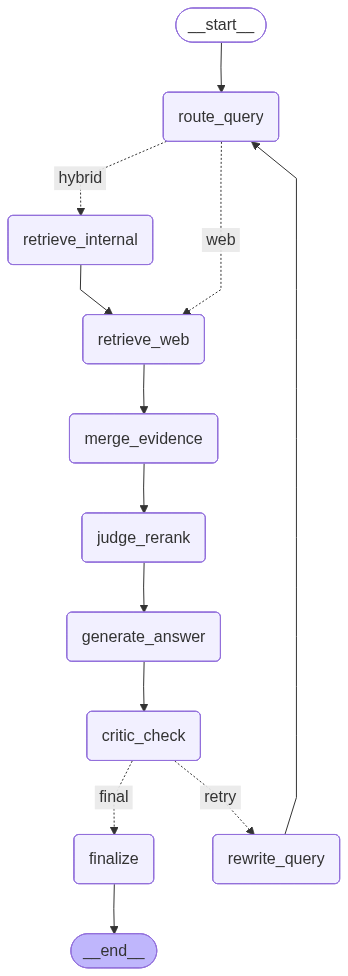

In [71]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# **Demo Runner (educational-purpose-friendly)**

**Run helper with observability**

In [72]:
def run_demo(query: str):
    initial_state: GraphState = {
        "query": query,
        "route": None,
        "route_reason": None,
        "internal_docs": [],
        "web_docs": [],
        "evidence_pool": [],
        "top_evidence": None,
        "confidence": 0.0,
        "draft_answer": None,
        "critic_verdict": None,
        "critic_reason": None,
        "retry_count": 0,
        "final_answer": None,
    }

    out = graph.invoke(initial_state)

    print("QUERY:", query)
    print("ROUTE:", out.get("route"), "| Reason:", out.get("route_reason"))
    print("RETRY_COUNT:", out.get("retry_count"))
    print("CONFIDENCE:", out.get("confidence"))
    print("CRITIC:", out.get("critic_verdict"), "|", out.get("critic_reason"))
    print("\nTOP EVIDENCE:\n", (out.get("top_evidence") or "")[:600], "...\n")
    print("FINAL ANSWER:\n", out.get("final_answer"))

    return out


# **Demos aligned with the blog**

**Demo 1: Internal truth**

In [73]:
run_demo("What is our refund policy for annual plans?")

QUERY: What is our refund policy for annual plans?
ROUTE: internal | Reason: Refund terms for annual plans are defined in internal company policies (policies/runbooks) and are not specified in public sources. To answer precisely, consult the internal refund policy document or contact the policy owner (product/finance).
RETRY_COUNT: 0
CONFIDENCE: 0.92
CRITIC: PASS | The draft answer directly mirrors the evidence: annual plans are refundable within 14 days of purchase if usage is below 20%. It does not add unsupported details or conditions.

TOP EVIDENCE:
 Refund Policy: Annual plans can be refunded within 14 days of purchase if usage is below 20%. Monthly plans are non-refundable. ...

FINAL ANSWER:
 Our refund policy for annual plans is: **Annual plans can be refunded within 14 days of purchase if usage is below 20%.**


{'query': 'What is our refund policy for annual plans?',
 'route': 'internal',
 'route_reason': 'Refund terms for annual plans are defined in internal company policies (policies/runbooks) and are not specified in public sources. To answer precisely, consult the internal refund policy document or contact the policy owner (product/finance).',
 'internal_docs': ['Refund Policy: Annual plans can be refunded within 14 days of purchase if usage is below 20%. Monthly plans are non-refundable.',
  'Product Notes: Our platform includes a centralized dashboard, user access controls, and audit logging for compliance reporting.',
  'Security Standard: Production databases must not be exposed to the public internet. Use private subnets, IAM auth, and approved ingress controls.',
  'On-call Runbook: For Sev1 incidents, declare incident within 5 minutes, assign incident commander, and update status every 15 minutes.'],
 'web_docs': ['Annual: $199 per year for 70GB of high-speed data. "US Mobile unlim

**Demo 2: Web freshness**

In [74]:
run_demo("What happened this week with Nvidia in the markets?")

QUERY: What happened this week with Nvidia in the markets?
ROUTE: web | Reason: The question asks for current market events involving Nvidia this week, which are time-sensitive external facts best covered by up-to-date web sources (latest news, stock moves, statements) rather than internal documents.
RETRY_COUNT: 0
CONFIDENCE: 0.84
CRITIC: PASS | The draft accurately repeats the key facts from the evidence: a 1.4% dip on Jan 14–15, 2026; described as a small move that nonetheless sent a disproportionate shockwave through trading floors; and it notes broader turbulence in the AI sector and the revived debate over whether the AI data-center boom is a sustainable Giga-Cycle or a bubble.

TOP EVIDENCE:
 By: MarketMinute

January 19, 2026 at 10:24 AM EST

The artificial intelligence sector, a behemoth that has dictated market direction for the past three years, hit a rare pocket of turbulence this week. On January 14 and 15, 2026, shares of NVIDIA (Nasdaq: NVDA) experienced a 1.4% dip, a mo

{'query': 'What happened this week with Nvidia in the markets?',
 'route': 'web',
 'route_reason': 'The question asks for current market events involving Nvidia this week, which are time-sensitive external facts best covered by up-to-date web sources (latest news, stock moves, statements) rather than internal documents.',
 'internal_docs': [],
 'web_docs': ['This week\'s list looks at the 20 stocks followed most closely by Argus clients in 2025. It contains well-known names and, not surprisingly, includes many technology or "technology related" names. One might have easily guessed that Nvidia is in the top spot, but might be surprised to see only three Healthcare companies, only one big box retailer, no big banks, and no Walmart. The list also includes the current Argus rating on each stock, the sector for each stock, and each stock\'s performance from 2025.\n\n  Argus• 14 days ago\n ### Nvidia: Approval to Sell H200 AI Accelerators Into China Appears Forthcoming; $240 Fair Value Kept 

**Demo 3: Out of scope refusal**

In [75]:
run_demo("How do I fix the roller window system in my car?")

QUERY: How do I fix the roller window system in my car?
ROUTE: hybrid | Reason: The repair of a car’s roller window system is model- and issue-specific (regulator/motor/track, glass type, car year/model) and may require up-to-date external instructions, while internal knowledge and safety guidelines provide general handling and diagnostics. A hybrid approach covers both generic guidance and model-specific steps.
RETRY_COUNT: 0
CONFIDENCE: 0.74
CRITIC: PASS | The draft answer uses only steps supported by the provided evidence: check the child safety lock, check/replace blown fuses using the owner’s manual, and keep the window tracks clean. It does not introduce reset steps for the motor (which aren’t specified in the evidence) and explicitly notes this gap.

TOP EVIDENCE:
 ### How to Fix a Stuck Car Window that Won’t Go Up

If your car window is stuck down, it could be due to a few different reasons, such as a blown fuse or a dying window motor. Follow these suggestions in order to try 

{'query': 'How do I fix the roller window system in my car?',
 'route': 'hybrid',
 'route_reason': 'The repair of a car’s roller window system is model- and issue-specific (regulator/motor/track, glass type, car year/model) and may require up-to-date external instructions, while internal knowledge and safety guidelines provide general handling and diagnostics. A hybrid approach covers both generic guidance and model-specific steps.',
 'internal_docs': ['On-call Runbook: For Sev1 incidents, declare incident within 5 minutes, assign incident commander, and update status every 15 minutes.',
  'Product Notes: Our platform includes a centralized dashboard, user access controls, and audit logging for compliance reporting.',
  'Refund Policy: Annual plans can be refunded within 14 days of purchase if usage is below 20%. Monthly plans are non-refundable.',
  'Security Standard: Production databases must not be exposed to the public internet. Use private subnets, IAM auth, and approved ingress 

**Demo 4: Self-correction success (vague query)**

In [76]:
run_demo("Can I expose the database to the internet?")

QUERY: Can I expose the database to the internet?
ROUTE: internal | Reason: According to internal security policies and runbooks, production databases must not be exposed directly to the internet. Use private networks with access via VPN/bastion, strict firewall rules, network segmentation, and least-privilege access; expose only through approved gateways if absolutely required.
RETRY_COUNT: 0
CONFIDENCE: 0.86
CRITIC: PASS | The draft answer is directly supported by the evidence: production databases must not be exposed to the public internet, and the recommended mitigations are private subnets, IAM authentication, and approved ingress controls.

TOP EVIDENCE:
 Security Standard: Production databases must not be exposed to the public internet. Use private subnets, IAM auth, and approved ingress controls. ...

FINAL ANSWER:
 No. The security standard states that **production databases must not be exposed to the public internet**. Instead, use **private subnets**, **IAM authentication**,

{'query': 'Can I expose the database to the internet?',
 'route': 'internal',
 'route_reason': 'According to internal security policies and runbooks, production databases must not be exposed directly to the internet. Use private networks with access via VPN/bastion, strict firewall rules, network segmentation, and least-privilege access; expose only through approved gateways if absolutely required.',
 'internal_docs': ['Security Standard: Production databases must not be exposed to the public internet. Use private subnets, IAM auth, and approved ingress controls.',
  'Product Notes: Our platform includes a centralized dashboard, user access controls, and audit logging for compliance reporting.',
  'Refund Policy: Annual plans can be refunded within 14 days of purchase if usage is below 20%. Monthly plans are non-refundable.',
  'On-call Runbook: For Sev1 incidents, declare incident within 5 minutes, assign incident commander, and update status every 15 minutes.'],
 'web_docs': ["To eva